<h2><center>Coding Discussion 06 

1.) Using scikit learn build a model that predicts the _log_ selling price of a house in DC (`PRICE`).  

2.) Using the training data, build a model that predicts the price of a residential unit in District of Columbia.

You may use any feature in the dataset to generate a model. Some things to keep in mind:

- Predict the log Price 
- Pre-process your data. 
- Handle missing values  
- Try different models some algorithms perform better on a specific data outcome than others. 
- Tune your model 

3.) Once you've come up with a model that you think performs well, please test your model on the provided test data and report the mean squared error. 


In [94]:
# Import packages 
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [95]:
# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [96]:
# Load data 
dta = pd.read_csv("train_data.csv") # Training data
dta_test = pd.read_csv("test_data.csv") # Test data 

<h3><center> Data Exploration

<AxesSubplot:>

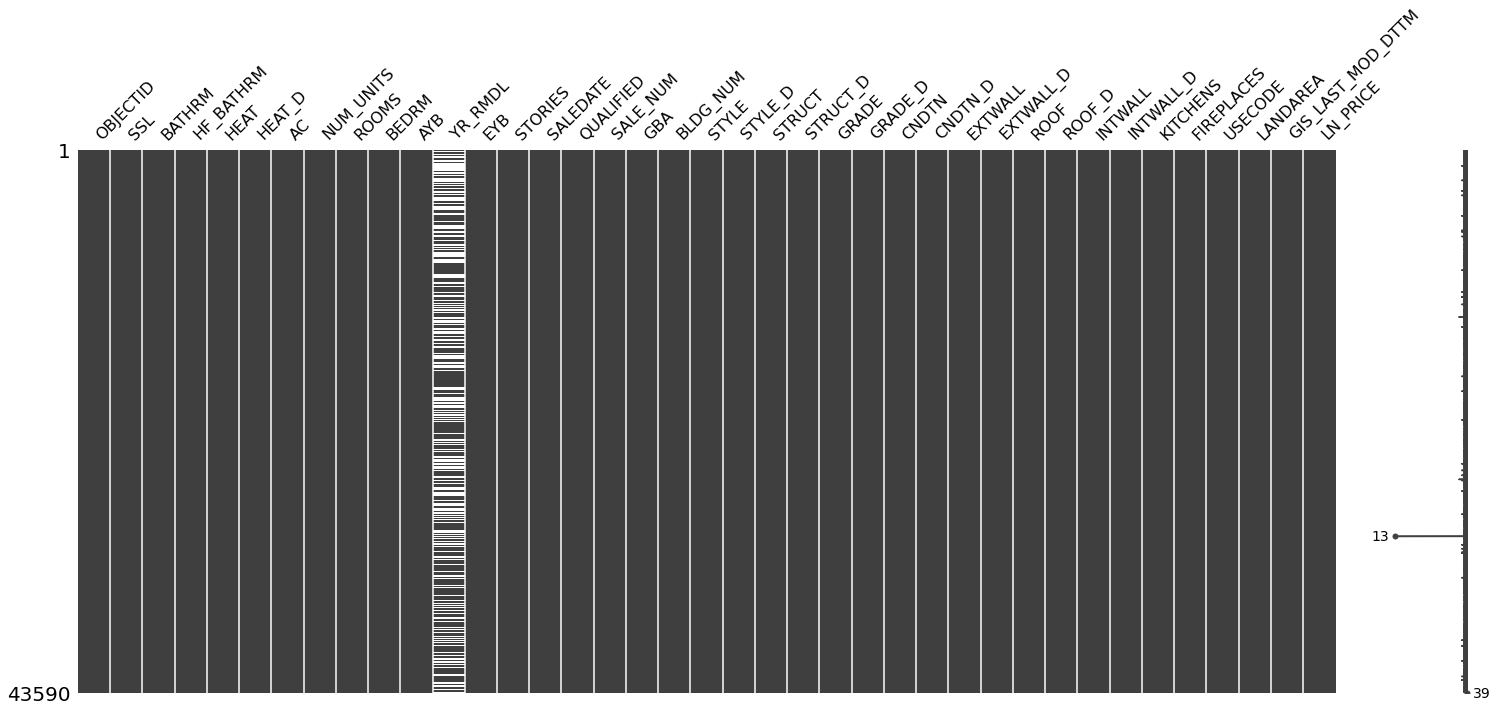

In [97]:
# Identify missing data for training 
miss.matrix(dta)

In [98]:
# Clean training data 
dta = dta.dropna() # Drop missing values 
dta = dta.replace([np.inf, -np.inf, -0], 0) # Replace float inf with zeroes 

dta['LANDAREA'] = np.log(dta['LANDAREA']) # Log land area
train_y = dta['LN_PRICE'] # OUTCOME
train_X = dta[['CNDTN','BEDRM','LANDAREA']] # PREDICTORS
train_X.shape # Dimensions of predictors 

(24998, 3)

In [99]:
# Clean test data 
dta_test['LANDAREA'] = np.log(dta_test['LANDAREA'])
dta_test = dta_test.dropna()
dta_test = dta_test.replace([np.inf, -np.inf, -0], 0)

test_y = dta_test['LN_PRICE'] 
test_X = dta_test[['CNDTN','BEDRM','LANDAREA']] 
test_X.shape

(8328, 3)

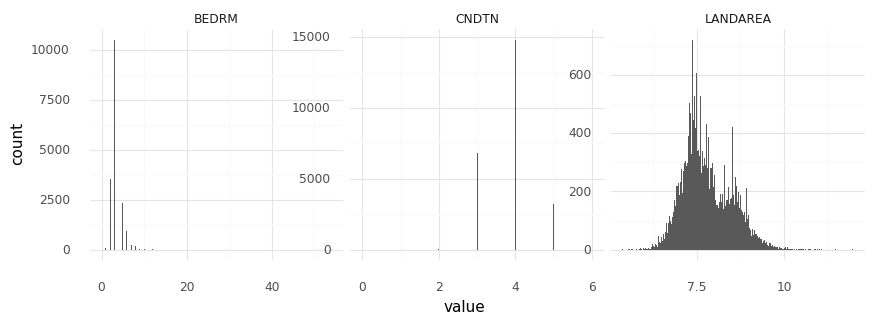

<ggplot: (-9223372036534993685)>

In [100]:
# Plot feature distributions 
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
) 


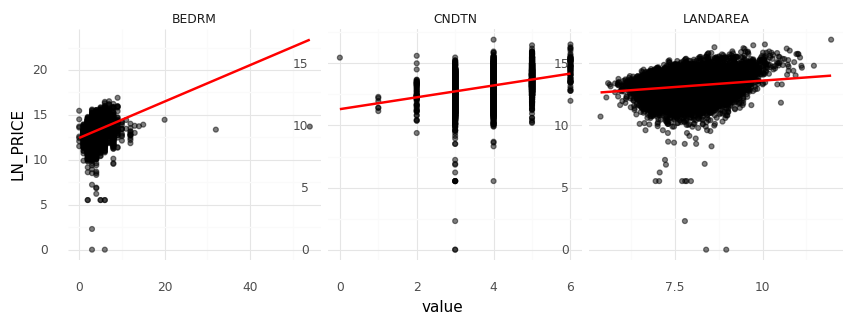

<ggplot: (-9223372036532624359)>

In [102]:
D = train_X.copy()
D['LN_PRICE'] = train_y

(
    ggplot(D.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

<h3><center> Pre-processing

In [103]:
# Scale data 
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)

# Scale test data 
scaler = pp.MinMaxScaler()
col_names = list(test_X)
test_X = scaler.fit_transform(test_X)

# Convert back into data frame
test_X = pd.DataFrame(test_X,columns=col_names)

In [104]:
# Specify Kfold splits 
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)
use_metrics = ["neg_mean_squared_error"]

<h3><center> Run the Models

In [107]:
# Linear 
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

# KNN 
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

# Decision Trees
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
mod = DTree(max_depth=3) # Initialize the modeling object 
mod.fit(train_X,train_y) # Fit the model 

# Bagging 
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

# Random Forest 
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

<h3><center> Compare Models

In [108]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.445527
1,lm,0.487392
2,lm,0.531529
3,lm,0.503801
4,lm,0.473072
5,knn,0.499013
6,knn,0.531401
7,knn,0.573641
8,knn,0.542164
9,knn,0.506891


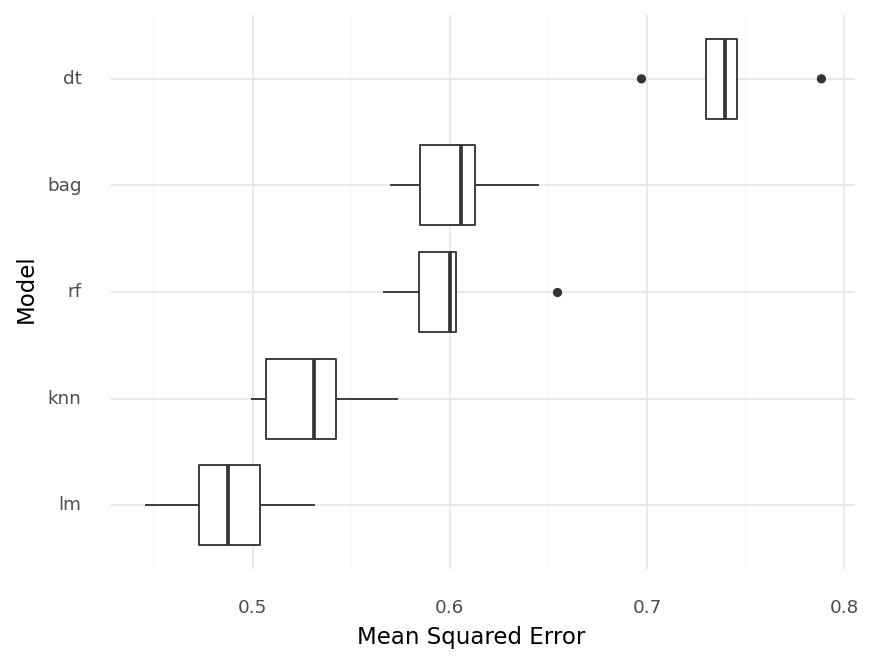

<ggplot: (319064566)>

In [109]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

<h3><center> Tuning Hyper-parameters

<h4> KNN 

In [110]:
mod = KNN() # Initialize the model class
mod.get_params() # report all the available tunning parameters 

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [111]:
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}

In [112]:
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [113]:
tune_knn.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_neighbors': [1, 10, 25, 35, 50, 75, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [114]:
tune_knn.best_params_

{'n_neighbors': 75}

In [115]:
tune_knn.best_score_

-0.45611028982430524

<h4> Decision Tree

In [116]:
DTree().get_params()

{'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [117]:
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(1,10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)
tune_dt

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
       error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [118]:
tune_dt.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
       error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [119]:
tune_dt.best_params_

{'max_depth': 6}

In [120]:
tune_dt.best_score_

-0.459999706670353

<h4> Random Forest 

In [121]:
RF().get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [122]:
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
              'max_features': [1,2]} # Only have three total. 
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [123]:
tune_rf.fit(train_X,train_y) 

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [1, 2, 3], 'n_estimators': [100, 500, 1000], 'max_features': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [124]:
tune_rf.best_params_

{'max_depth': 3, 'max_features': 2, 'n_estimators': 1000}

In [125]:
tune_rf.best_score_

-0.4776542935642371

<h3><center> Modeling Pipeline

In [126]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['CNDTN','BEDRM','LANDAREA'])])

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[25,50,75,100]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[4,5,6,7,8]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[2,3,4],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pre_process', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', MinMaxScaler(copy=True, feature_range=(0, 1)), ['CNDTN', 'BEDRM', 'LANDAREA'])])), ('model', None)]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'model': [LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)]}, {'model': [KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=75, p=2,
          weights='uniform')], 'model_...ose=0, warm_start=False)], 'model__max_depth': [2, 3, 4], 'model__n_estimators': [500, 1000, 1250]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [127]:
search.best_score_ # Mean out-of-sample (CV) error

-0.4559791775072516

In [128]:
search.best_params_

{'model': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=75, p=2,
           weights='uniform'), 'model__n_neighbors': 75}

<h3><center> Test Peformance

In [129]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [130]:
# MSE 
m.mean_squared_error(test_y,pred_y)

0.44101219592902907

In [131]:
# R-squared 
m.r2_score(test_y,pred_y)

0.2722631783759518

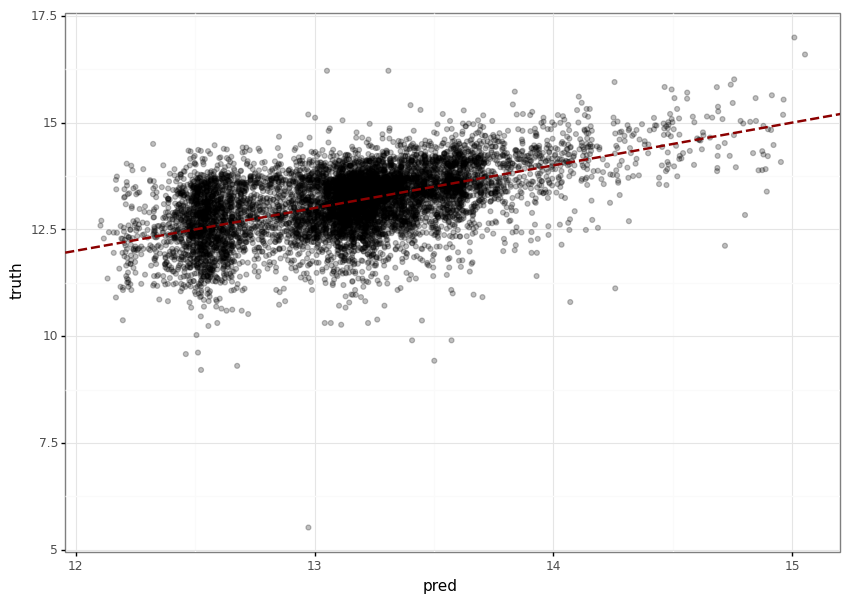

<ggplot: (319083805)>

In [132]:
# Plot performance 
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.25) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

<h3><center> 2nd Model 

In [133]:
# Clean training data 
dta = dta.dropna() # Drop missing values 
dta = dta.replace([np.inf, -np.inf, -0], 0) # Replace float inf with zeroes 

dta['GBA'] = np.log(dta['GBA']) # Log building area 
train_y = dta['LN_PRICE'] # OUTCOME
train_X = dta[['CNDTN','BEDRM','GBA','STYLE']] # PREDICTORS
train_X.shape # Dimensions of predictors 

(24998, 4)

In [134]:
# Clean test data 
dta_test['GBA'] = np.log(dta_test['GBA'])
dta_test = dta_test.dropna()
dta_test = dta_test.replace([np.inf, -np.inf, -0], 0)

test_y = dta_test['LN_PRICE'] 
test_X = dta_test[['CNDTN','BEDRM','GBA','STYLE']] 
test_X.shape

(8328, 4)

In [135]:
# Scale training data 
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)

# Scale test data 
scaler = pp.MinMaxScaler()
col_names = list(test_X)
test_X = scaler.fit_transform(test_X)

# Convert back into data frame
test_X = pd.DataFrame(test_X,columns=col_names)

In [136]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['CNDTN','BEDRM','GBA','STYLE'])])

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[25,50,75,100]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[4,5,6,7,8]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[2,3,4],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pre_process', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', MinMaxScaler(copy=True, feature_range=(0, 1)), ['CNDTN', 'BEDRM', 'GBA', 'STYLE'])])), ('model', None)]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'model': [LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)]}, {'model': [KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=75, p=2,
          weights='uniform')], 'model_...ose=0, warm_start=False)], 'model__max_depth': [2, 3, 4], 'model__n_estimators': [500, 1000, 1250]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [137]:
pred_y = search.predict(test_X)

In [138]:
# MSE 
m.mean_squared_error(test_y,pred_y)

0.40994802030377325

In [139]:
# R-squared 
m.r2_score(test_y,pred_y)

0.32352376627935964

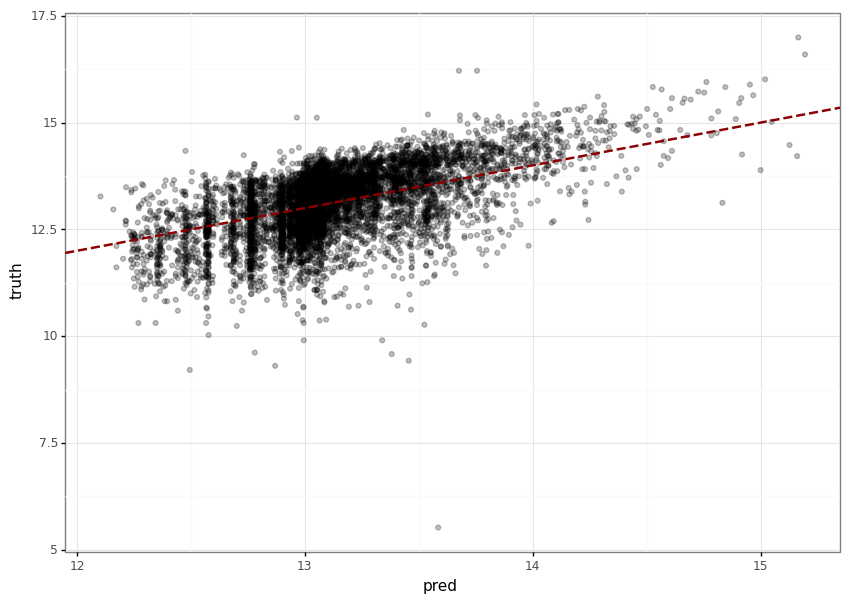

<ggplot: (318651533)>

In [141]:
# Plot performance 
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.25) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

It appears that our second model is a better predictor of the log housing price in D.C. by a slight margin (MSE of .441 compared to .409). We do have a 4th predictor in our second model, so the models have more parameters to draw from, which could lead to increased accuracy.